<a href="https://colab.research.google.com/github/cinnaavox/favorita_sales_forecasting/blob/main/Week_1_data_prep_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🧱 Block 0 – Setup

In [1]:
# Ruhe in die Konsole bringen
import warnings, pandas as pd, numpy as np
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

# Plot-Optik: groß & clean
import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.figsize": (12,5),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

## 🧱 Block 1 – Drive mount + zwei Lade-Wege (Drive → Fallback per File-ID)

In [2]:
!pip -q install pyarrow fastparquet gdown

import os, io, gc, requests, pandas as pd, numpy as np, gdown

# ---- Utilities
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

def load_csv_from_url(url):
    r = requests.get(url); r.raise_for_status()
    return pd.read_csv(io.StringIO(r.text))

# ---- File IDs (deine Liste)
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items":          "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil":            "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores":         "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train":          "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions":   "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

# ---- Load Meta (klein): direkt ins RAM
df_items        = load_csv_from_url(make_drive_url(file_ids["items"]))
df_stores       = load_csv_from_url(make_drive_url(file_ids["stores"]))
df_oil          = load_csv_from_url(make_drive_url(file_ids["oil"]))
df_transactions = load_csv_from_url(make_drive_url(file_ids["transactions"]))
df_holidays     = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))

# Datumsfelder & Öl-Gaps
for _df, col in [(df_oil,'date'), (df_transactions,'date'), (df_holidays,'date')]:
    _df[col] = pd.to_datetime(_df[col], errors='coerce')
df_oil['dcoilwtico'] = pd.to_numeric(df_oil['dcoilwtico'], errors='coerce').interpolate('linear').ffill().bfill()

print({
    'items': df_items.shape, 'stores': df_stores.shape, 'oil': df_oil.shape,
    'transactions': df_transactions.shape, 'holiday': df_holidays.shape
})

# ---- train.csv (groß): per gdown als Datei laden, falls nicht vorhanden
TRAIN_PATH = "/content/train.csv"
if not os.path.exists(TRAIN_PATH):
    gdown.download(make_drive_url(file_ids["train"]), TRAIN_PATH, quiet=False)
print("train.csv bereit:", os.path.getsize(TRAIN_PATH)//(1024*1024), "MB")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.5 MB/s eta 0:00:00
{'items': (4100, 4), 'stores': (54, 5), 'oil': (1218, 2), 'transactions': (83488, 3), 'holiday': (350, 6)}


Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=af42eec5-7619-4814-b523-c6d72f3762a6
To: /content/train.csv
100%|██████████| 5.00G/5.00G [01:52<00:00, 44.6MB/s]

train.csv bereit: 4765 MB


## 🧱 Block 2 – Datums-/Basis-Fixes (einmal sauber machen)

In [3]:
for _df, col in [(df_oil,'date'), (df_transactions,'date'), (df_holidays,'date')]:
    if col in _df.columns:
        _df[col] = pd.to_datetime(_df[col], errors='coerce')

# Ölpreis-Lücken glatt ziehen
df_oil['dcoilwtico'] = pd.to_numeric(df_oil['dcoilwtico'], errors='coerce').interpolate('linear').ffill().bfill()

# Guayas-Stores
guayas_store_ids = df_stores[df_stores['state']=='Guayas']['store_nbr'].unique()
print("Guayas stores:", len(guayas_store_ids))


Guayas stores: 11


## 🧱 Block 3 – train.csv chunk-weise laden (nur Guayas)

In [4]:
# 🧱 Block 3 – train.csv chunk-weise laden (nur Guayas)
import pandas as pd
import os

chunk_size = 10**6
filtered_chunks = []

# 🔹 Train-Pfad (je nach Setup)
TRAIN_PATH = "/content/train.csv"
if not os.path.exists(TRAIN_PATH):
    raise FileNotFoundError("train.csv wurde nicht gefunden. Stelle sicher, dass sie mit gdown geladen wurde.")

# Kopf lesen, um Spalten-Schema zu erkennen
header_df = pd.read_csv(TRAIN_PATH, nrows=5)
cols = set(header_df.columns)

# Felder je nach Wettbewerb
HAS_ITEM   = 'item_nbr' in cols        # Favorita (alt)
HAS_SALES  = 'unit_sales' in cols      # Favorita (alt)
HAS_FAMILY = 'family' in cols          # Store Sales (neu)
HAS_SALES2 = 'sales' in cols           # Store Sales (neu)

# Einheitliche Namen
DATE_COL   = 'date'
STORE_COL  = 'store_nbr'
ITEM_COL   = 'item_nbr' if HAS_ITEM else ('family' if HAS_FAMILY else None)
TARGET_COL = 'unit_sales' if HAS_SALES else ('sales' if HAS_SALES2 else None)
PROMO_COL  = 'onpromotion' if 'onpromotion' in cols else None

if ITEM_COL is None or TARGET_COL is None:
    raise ValueError(f"Unbekanntes Schema in train.csv. Gefundene Spalten: {sorted(list(cols))}")

use_cols = [c for c in ['id', DATE_COL, STORE_COL, ITEM_COL, TARGET_COL, PROMO_COL] if c is not None]

print("→ erkanntes Schema:",
      f"ITEM_COL={ITEM_COL}  TARGET_COL={TARGET_COL}  PROMO_COL={PROMO_COL}")

# 🔹 Guayas-Store-IDs sicherstellen
if 'guayas_store_ids' not in globals():
    guayas_store_ids = df_stores.loc[df_stores['state'].str.upper().str.strip() == 'GUAYAS', 'store_nbr'].unique()
    print(f"Guayas-Stores erkannt: {len(guayas_store_ids)}")

# 🔹 Chunk-weise laden & filtern
for i, chunk in enumerate(pd.read_csv(TRAIN_PATH, chunksize=chunk_size, usecols=use_cols, low_memory=False)):
    chunk = chunk[chunk[STORE_COL].isin(guayas_store_ids)]
    filtered_chunks.append(chunk)
    del chunk
    if (i+1) % 5 == 0:
        print(f"… {i+1} Chunks verarbeitet")

df_train = pd.concat(filtered_chunks, ignore_index=True)
del filtered_chunks

# 🔹 Optionale Drosselung
if len(df_train) > 2_000_000:
    df_train = df_train.sample(n=2_000_000, random_state=42).reset_index(drop=True)

print("✅ df_train:", df_train.shape, "| Zeitraum:",
      df_train[DATE_COL].min(), "→", df_train[DATE_COL].max())

→ erkanntes Schema: ITEM_COL=item_nbr  TARGET_COL=unit_sales  PROMO_COL=onpromotion
… 5 Chunks verarbeitet
… 10 Chunks verarbeitet
… 15 Chunks verarbeitet
… 20 Chunks verarbeitet
… 25 Chunks verarbeitet
… 30 Chunks verarbeitet
… 35 Chunks verarbeitet
… 40 Chunks verarbeitet
… 45 Chunks verarbeitet
… 50 Chunks verarbeitet
… 55 Chunks verarbeitet
… 60 Chunks verarbeitet
… 65 Chunks verarbeitet
… 70 Chunks verarbeitet
… 75 Chunks verarbeitet
… 80 Chunks verarbeitet
… 85 Chunks verarbeitet
… 90 Chunks verarbeitet
… 95 Chunks verarbeitet
… 100 Chunks verarbeitet
… 105 Chunks verarbeitet
… 110 Chunks verarbeitet
… 115 Chunks verarbeitet
… 120 Chunks verarbeitet
… 125 Chunks verarbeitet
✅ df_train: (2000000, 6) | Zeitraum: 2013-01-02 → 2017-08-15


##Block 4 (Top-3 “Familien/Items” wählen)

In [5]:
if HAS_ITEM:
    # Favorita (alt): Top-3 Familien via items.csv
    items_per_family = df_items['family'].value_counts().reset_index()
    items_per_family.columns = ['family','item_count']
    top3_families = items_per_family.head(3)['family'].tolist()
    print("Top-3 Familien (items.csv):", top3_families)

    # nur Items aus diesen Familien behalten
    keep_items = df_items[df_items['family'].isin(top3_families)]['item_nbr'].unique()
    df_train = df_train[df_train[ITEM_COL].isin(keep_items)].reset_index(drop=True)
else:
    # Store Sales (neu): family ist schon da → Top-3 direkt aus train
    top3_families = (
        df_train.groupby('family')[TARGET_COL].count()
        .sort_values(ascending=False)
        .head(3)
        .index.tolist()
    )
    print("Top-3 Familien (train):", top3_families)
    df_train = df_train[df_train['family'].isin(top3_families)].reset_index(drop=True)

print("nach Top-3-Filter:", df_train.shape)

Top-3 Familien (items.csv): ['GROCERY I', 'BEVERAGES', 'CLEANING']
nach Top-3-Filter: (1285637, 6)


## Block 5 (Cleaning, schema-agnostisch)

In [6]:
# Datumsfeld vereinheitlichen
df_train[DATE_COL] = pd.to_datetime(df_train[DATE_COL], errors='coerce')

# Promo in bool
if PROMO_COL is not None:
    df_train[PROMO_COL] = df_train[PROMO_COL].fillna(False).astype(bool)

# Negative Sales clippen
neg_cnt = (df_train[TARGET_COL] < 0).sum()
df_train.loc[df_train[TARGET_COL] < 0, TARGET_COL] = 0
print("negatives vorher:", neg_cnt, "| jetzt:", (df_train[TARGET_COL] < 0).sum())

negatives vorher: 84 | jetzt: 0


## Block 6 (Z-Score je Serie)

Ausreißer > 5σ: 3421


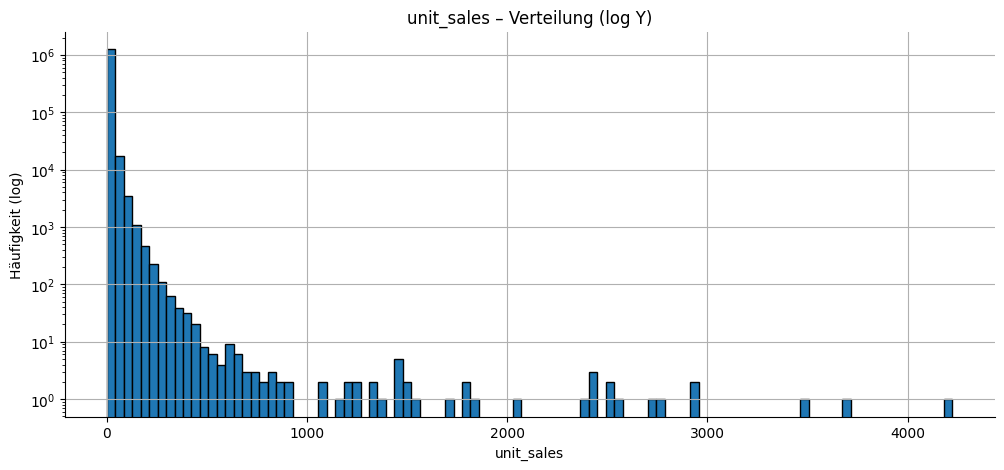

In [7]:
# Gruppe = (store, item/family)
grp_cols = [STORE_COL, ITEM_COL]

def z_score_per_group(g):
    mu, sigma = g[TARGET_COL].mean(), g[TARGET_COL].std()
    sigma = 1.0 if pd.isna(sigma) or sigma==0 else sigma
    g['z_score'] = (g[TARGET_COL] - mu) / sigma
    return g

df_z = df_train.groupby(grp_cols, group_keys=False).apply(z_score_per_group)
outliers = df_z[df_z['z_score'] > 5]
print("Ausreißer > 5σ:", len(outliers))

# grobe Verteilung
plt.figure()
plt.hist(df_train[TARGET_COL], bins=100, edgecolor='k')
plt.yscale('log'); plt.title(f'{TARGET_COL} – Verteilung (log Y)')
plt.xlabel(TARGET_COL); plt.ylabel('Häufigkeit (log)'); plt.show()

## Block 7 (Kalender auffüllen + Zeitfeatures + 7-Tage-Mean)

In [8]:
def fill_calendar(g):
    g = g.set_index(DATE_COL).sort_index()
    g = g.asfreq('D', fill_value=0)
    # verloren gegangene Keys wieder anheften
    g[STORE_COL] = g[STORE_COL].iloc[0]
    g[ITEM_COL]  = g[ITEM_COL].iloc[0]
    if PROMO_COL is not None and PROMO_COL in g.columns:
        g[PROMO_COL] = g[PROMO_COL].astype(bool)
    return g.reset_index()

df_filled = (
    df_train
    .groupby([STORE_COL, ITEM_COL], group_keys=False)
    .apply(fill_calendar)
)

# Zeitfeatures
df_filled['year']        = df_filled[DATE_COL].dt.year
df_filled['month']       = df_filled[DATE_COL].dt.month
df_filled['day']         = df_filled[DATE_COL].dt.day
df_filled['day_of_week'] = df_filled[DATE_COL].dt.dayofweek

# 7-Tage rolling mean pro Serie
df_filled['target_7d_avg'] = (
    df_filled
    .groupby([STORE_COL, ITEM_COL])[TARGET_COL]
    .transform(lambda s: s.rolling(7, min_periods=1).mean())
)

print("df_filled:", df_filled.shape,
      "| Zeitraum:", df_filled[DATE_COL].min(), "→", df_filled[DATE_COL].max())

df_filled: (22284928, 11) | Zeitraum: 2013-01-02 00:00:00 → 2017-08-15 00:00:00


##Block 8 (Save prepared)

In [9]:
import os
SAVE_DIR = "/content/drive/MyDrive/time_series_course_guayas"
os.makedirs(SAVE_DIR, exist_ok=True)

# Dateiname je nach Schema, damit klar ist was drin steckt
fname = "df_prepared_guayas_store_sales.csv" if HAS_FAMILY and not HAS_ITEM else "df_prepared_guayas_favorita.csv"
save_path = os.path.join(SAVE_DIR, fname)

df_filled.to_csv(save_path, index=False)
print("gespeichert →", save_path)

gespeichert → /content/drive/MyDrive/time_series_course_guayas/df_prepared_guayas_favorita.csv


## Block 9 (EDA – generisch)

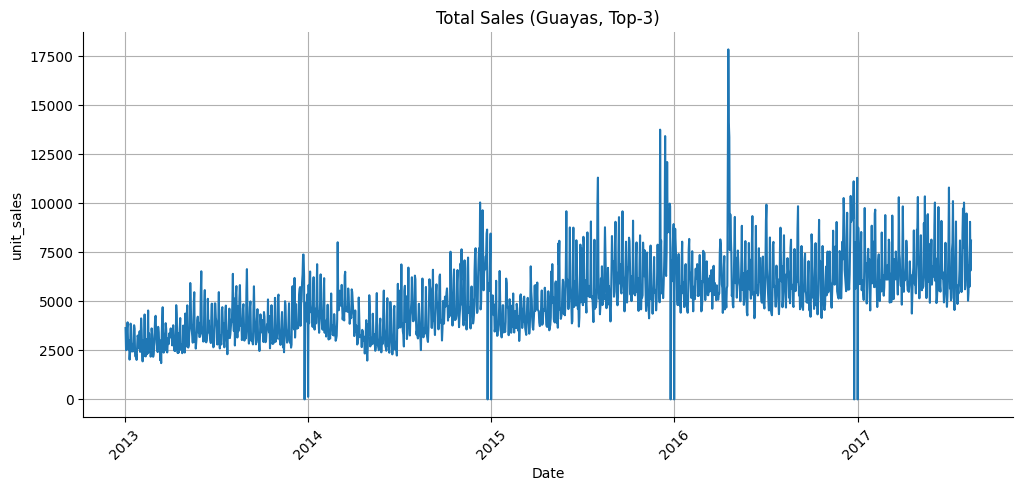

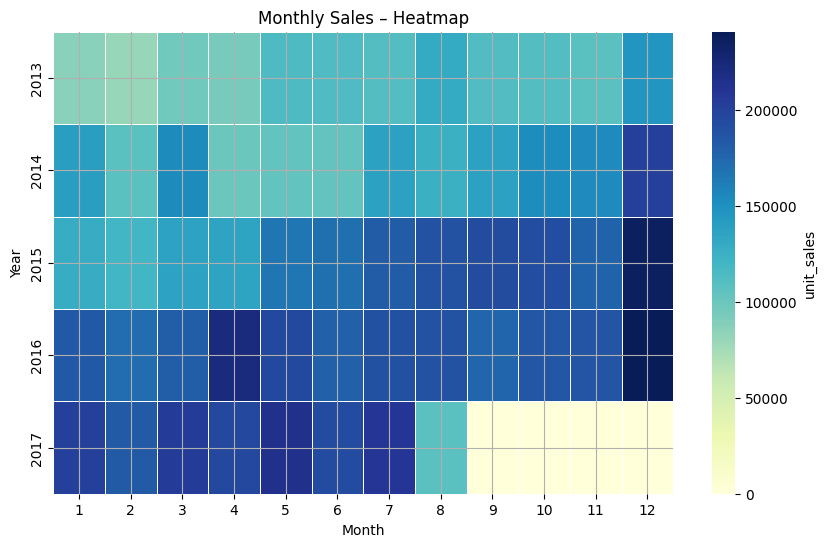

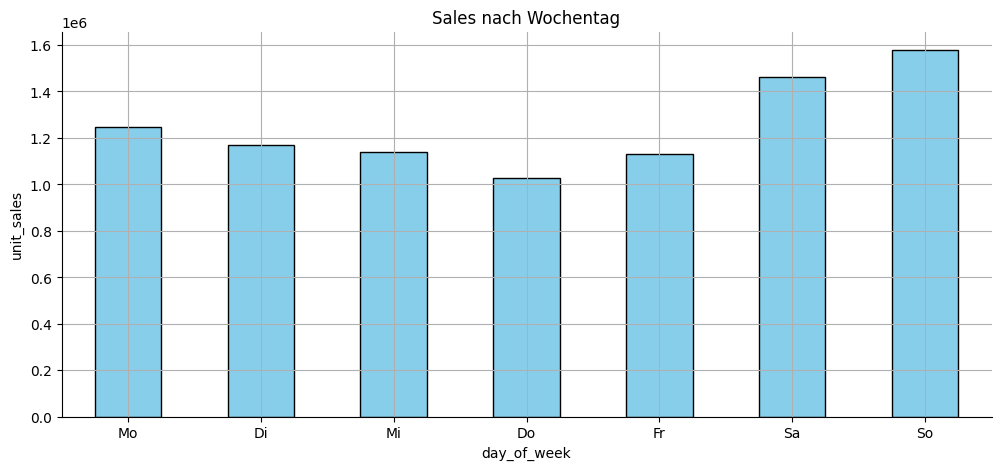

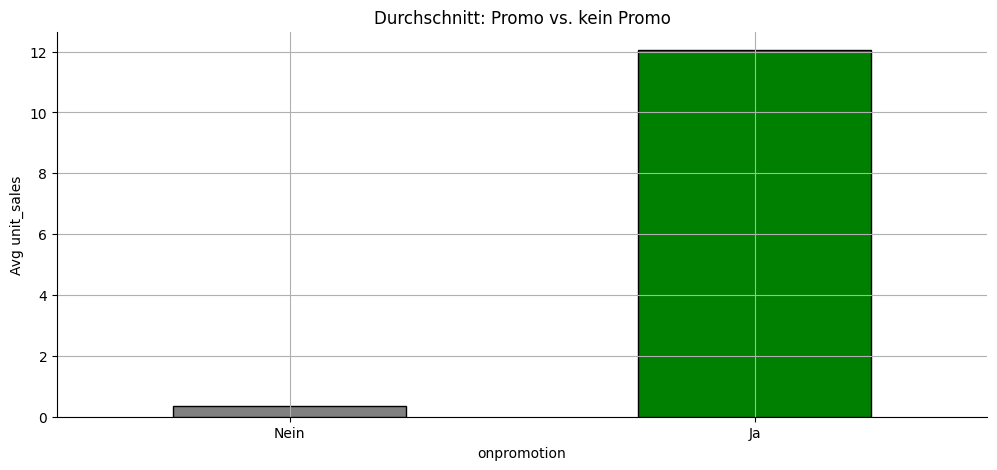

In [10]:
# 1) Total Sales über die Zeit
daily = df_filled.groupby(DATE_COL)[TARGET_COL].sum()
plt.figure(); plt.plot(daily.index, daily.values)
plt.title('Total Sales (Guayas, Top-3)'); plt.xlabel('Date'); plt.ylabel(TARGET_COL)
plt.xticks(rotation=45); plt.show()

# 2) Monats-Heatmap
import seaborn as sns
monthly = df_filled.groupby(['year','month'])[TARGET_COL].sum().unstack(fill_value=0)
plt.figure(figsize=(10,6))
sns.heatmap(monthly, cmap="YlGnBu", linewidths=.5, cbar_kws={'label': TARGET_COL})
plt.title('Monthly Sales – Heatmap'); plt.xlabel('Month'); plt.ylabel('Year'); plt.show()

# 3) Wochentage
dow = df_filled.groupby('day_of_week')[TARGET_COL].sum()
plt.figure(); dow.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Sales nach Wochentag'); plt.xticks(ticks=range(7), labels=['Mo','Di','Mi','Do','Fr','Sa','So'], rotation=0)
plt.ylabel(TARGET_COL); plt.show()

# 4) Promo vs. No Promo
if PROMO_COL is not None:
    promo = df_filled.groupby(PROMO_COL)[TARGET_COL].mean()
    plt.figure(); promo.plot(kind='bar', color=['gray','green'], edgecolor='black')
    plt.title('Durchschnitt: Promo vs. kein Promo')
    plt.xticks(ticks=[0,1], labels=['Nein','Ja'], rotation=0)
    plt.ylabel(f'Avg {TARGET_COL}'); plt.show()

## Block 10 (Top-Kombos + Peak)

store_nbr  item_nbr
51         257847      25136.0
24         257847      21858.0
51         315176      17469.0
34         819932      16241.0
51         819932      15968.0
Name: unit_sales, dtype: float64


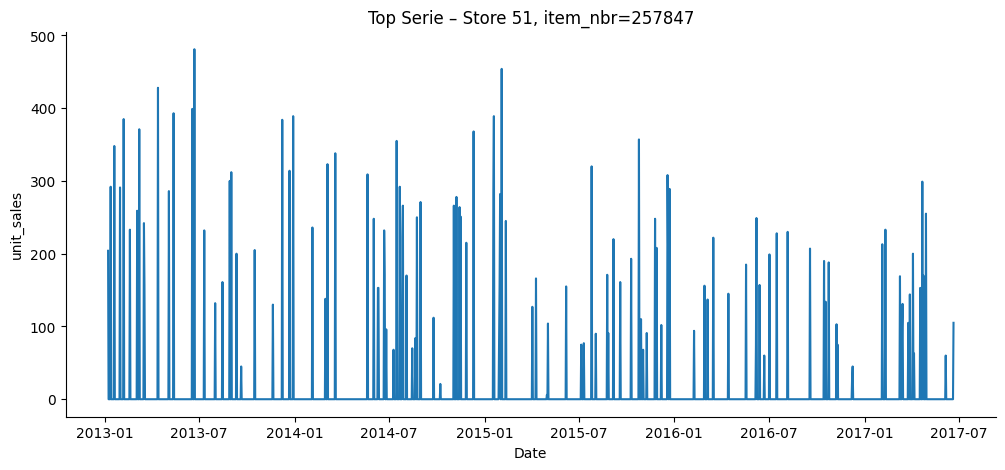

Peak-Datum: 2013-06-22 | Holiday-Treffer:
 Empty DataFrame
Columns: [date, type, locale, locale_name, description, transferred]
Index: []


In [11]:
grp_cols = [STORE_COL, ITEM_COL]
top_combos = (
    df_filled.groupby(grp_cols)[TARGET_COL]
    .sum().sort_values(ascending=False).head(5)
)
print(top_combos)

best_store, best_item = top_combos.index[0]
sample = df_filled[(df_filled[STORE_COL]==best_store) & (df_filled[ITEM_COL]==best_item)]

plt.figure(); plt.plot(sample[DATE_COL], sample[TARGET_COL])
plt.title(f"Top Serie – Store {best_store}, {ITEM_COL}={best_item}")
plt.xlabel("Date"); plt.ylabel(TARGET_COL); plt.grid(); plt.show()

# Peak + ggf. Holiday check
peak_row = sample.loc[sample[TARGET_COL].idxmax()]
peak_date = pd.to_datetime(peak_row[DATE_COL])

df_holidays['date'] = pd.to_datetime(df_holidays['date'], errors='coerce')
hit = df_holidays[df_holidays['date']==peak_date]
print("Peak-Datum:", peak_date.date(), "| Holiday-Treffer:\n", hit.head(3))

## 🧱 Block 11 — „Top Sales“ Leaderboards (Stores / Items/Families / Store×Item)

Schema: date store_nbr item_nbr unit_sales


,total_sales
store_nbr,
51,1524934.000
24,1131431.000
34,1020233.927
28,1014715.191
27,945217.000
36,878649.592
29,535590.991
35,483005.960
30,435080.068


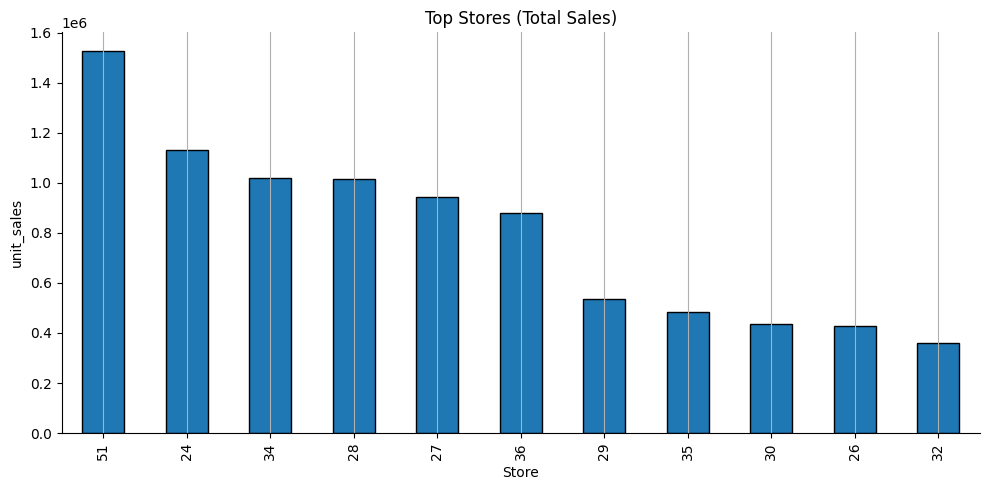

,total_sales
item_nbr,
257847,85328.0
819932,76096.0
215352,69534.0
839362,64392.0
315176,60283.0
265559,60039.0
364606,54419.0
559870,52779.0
1463860,47111.0


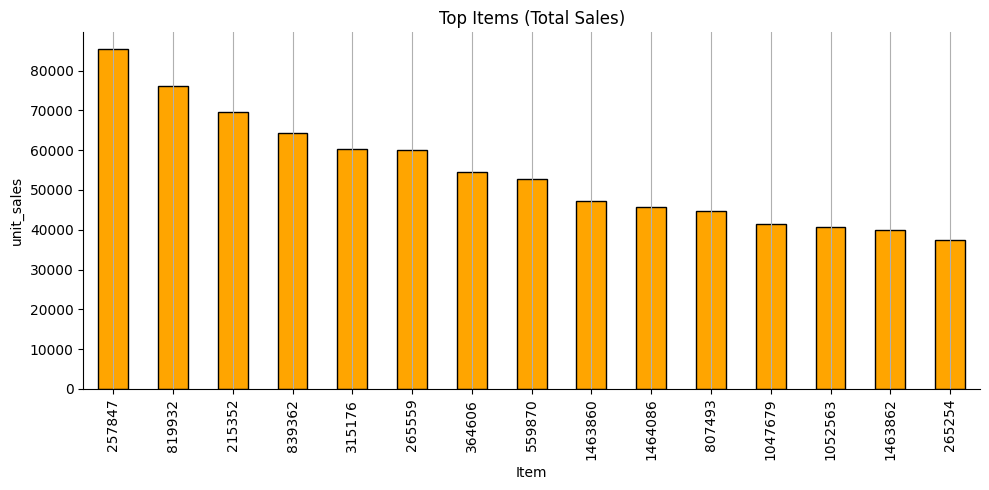

Top 10 Store×Serie:


store_nbr  item_nbr
51         257847      25136.0
24         257847      21858.0
51         315176      17469.0
34         819932      16241.0
51         819932      15968.0
           1430040     15789.0
           1047679     15655.0
           1463862     15307.0
24         819932      13512.0
27         315176      13153.0
Name: unit_sales, dtype: float64

In [12]:
# Annahme: df_filled existiert und hat DATE_COL, STORE_COL, ITEM_COL, TARGET_COL
import pandas as pd
import matplotlib.pyplot as plt

print("Schema:", DATE_COL, STORE_COL, ITEM_COL, TARGET_COL)

# 1) Top-Stores nach Gesamtabsatz
top_stores = (
    df_filled.groupby(STORE_COL)[TARGET_COL]
    .sum()
    .sort_values(ascending=False)
)
display(top_stores.head(10).to_frame("total_sales"))

plt.figure(figsize=(10,5))
top_stores.head(15).plot(kind='bar', edgecolor='black')
plt.title("Top Stores (Total Sales)")
plt.ylabel(TARGET_COL); plt.xlabel("Store")
plt.grid(axis='y'); plt.tight_layout(); plt.show()

# 2) Top Items/Families (je nach Schema)
if ITEM_COL == "item_nbr":
    top_items = (
        df_filled.groupby(ITEM_COL)[TARGET_COL]
        .sum()
        .sort_values(ascending=False)
    )
    display(top_items.head(10).to_frame("total_sales"))
    plt.figure(figsize=(10,5))
    top_items.head(15).plot(kind='bar', edgecolor='black', color='orange')
    plt.title("Top Items (Total Sales)"); plt.ylabel(TARGET_COL); plt.xlabel("Item")
    plt.grid(axis='y'); plt.tight_layout(); plt.show()
else:
    # Store Sales: ITEM_COL == 'family'
    top_families = (
        df_filled.groupby(ITEM_COL)[TARGET_COL]
        .sum()
        .sort_values(ascending=False)
    )
    display(top_families.head(10).to_frame("total_sales"))
    plt.figure(figsize=(10,5))
    top_families.head(15).plot(kind='bar', edgecolor='black', color='orange')
    plt.title("Top Families (Total Sales)"); plt.ylabel(TARGET_COL); plt.xlabel("Family")
    plt.grid(axis='y'); plt.tight_layout(); plt.show()

# 3) Top Store×Item/Familie-Kombinationen
top_pairs = (
    df_filled.groupby([STORE_COL, ITEM_COL])[TARGET_COL]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
print("Top 10 Store×Serie:")
display(top_pairs)

##🧱 Block 12 — Wochenrhythmus & Saison: DOW×Woche-des-Jahres Heatmap

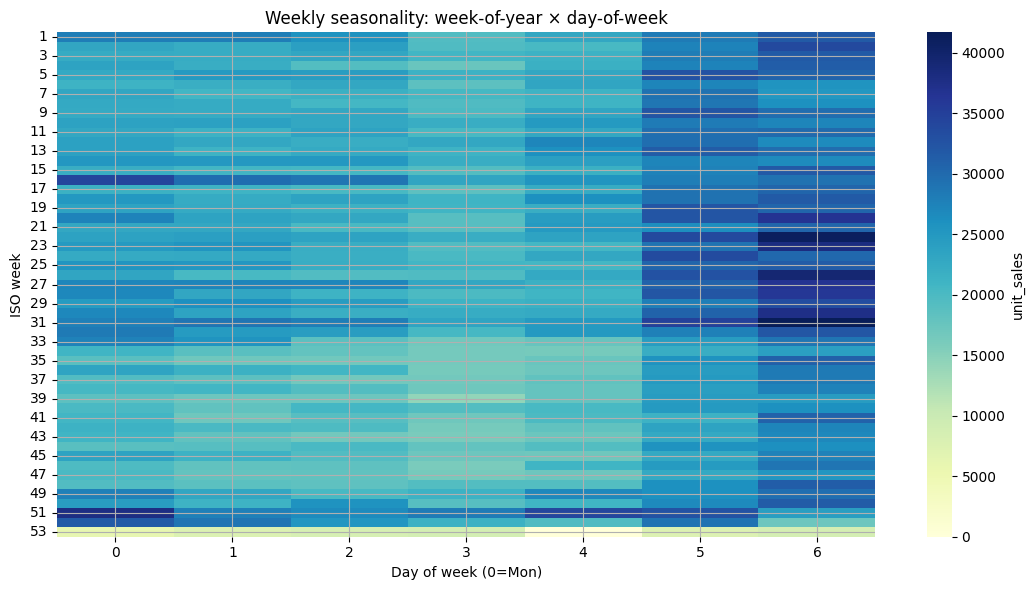

In [13]:
import numpy as np
import seaborn as sns

df_dow = df_filled.copy()
df_dow["weekofyear"] = df_dow[DATE_COL].dt.isocalendar().week.astype(int)
df_dow["dow"] = df_dow[DATE_COL].dt.dayofweek

pivot = df_dow.pivot_table(values=TARGET_COL, index="weekofyear", columns="dow", aggfunc="sum", fill_value=0)

plt.figure(figsize=(11,6))
sns.heatmap(pivot, cmap="YlGnBu", cbar_kws={'label': TARGET_COL})
plt.title("Weekly seasonality: week-of-year × day-of-week")
plt.xlabel("Day of week (0=Mon)")
plt.ylabel("ISO week")
plt.tight_layout(); plt.show()

## 🧱 Block 13 — Promo-Lift (durchschnittlicher Uplift) + Anteil Promo-Tage

Promo-Anteil der Tage: 0.27%
Durchschnitt: {False: 0.36174374942886417, True: 12.050253030481347}
≈ Promo-Uplift: 11.69 unit_sales (True − False)


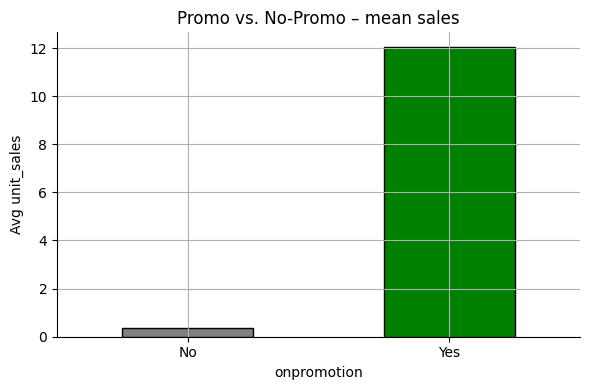

In [14]:
if PROMO_COL is not None and PROMO_COL in df_filled.columns:
    promo_stats = df_filled.groupby(PROMO_COL)[TARGET_COL].mean().rename("mean_sales")
    promo_share = df_filled[PROMO_COL].mean()  # Anteil True
    uplift = promo_stats.get(True, np.nan) - promo_stats.get(False, np.nan)

    print(f"Promo-Anteil der Tage: {promo_share:.2%}")
    print("Durchschnitt:", promo_stats.to_dict())
    print(f"≈ Promo-Uplift: {uplift:.2f} {TARGET_COL} (True − False)")

    plt.figure(figsize=(6,4))
    promo_stats.plot(kind='bar', color=['gray','green'], edgecolor='black')
    plt.title('Promo vs. No-Promo – mean sales')
    plt.xticks(ticks=[0,1], labels=['No','Yes'], rotation=0)
    plt.ylabel(f'Avg {TARGET_COL}')
    plt.tight_layout(); plt.show()
else:
    print("Kein Promo-Feld vorhanden – übersprungen.")

## 🧱 Block 14 — Ferien/Events: ±3-Tage-Fenster (einfacher Impact-Check)

In [15]:
# df_hols optional vorhanden (holidays_events.csv); falls nicht: überspringen
try:
    df_hols['date'] = pd.to_datetime(df_hols['date'], errors='coerce')
    holi_dates = set(df_hols['date'].dropna().unique())
    df_h = df_filled[[DATE_COL, TARGET_COL]].copy()
    df_h['is_holiday±3'] = df_h[DATE_COL].apply(
        lambda d: any(abs((d - h).days) <= 3 for h in holi_dates)
    ).astype(int)

    cmp = df_h.groupby('is_holiday±3')[TARGET_COL].mean()
    print("Mean sales – holiday±3 vs. normal:", cmp.to_dict())

    plt.figure(figsize=(6,4))
    cmp.plot(kind='bar', edgecolor='black')
    plt.title("Avg Sales around Holidays (±3 days)")
    plt.xticks(ticks=[0,1], labels=['Normal','Holiday±3'], rotation=0)
    plt.ylabel(f'Avg {TARGET_COL}')
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Holiday-Analyse übersprungen:", e)

Holiday-Analyse übersprungen: name 'df_hols' is not defined


## 🧱 Block 15 — Korrelation mit exogenen Reihen (Oil, Transactions)

Korrelation (Total Sales vs Oil): -0.636


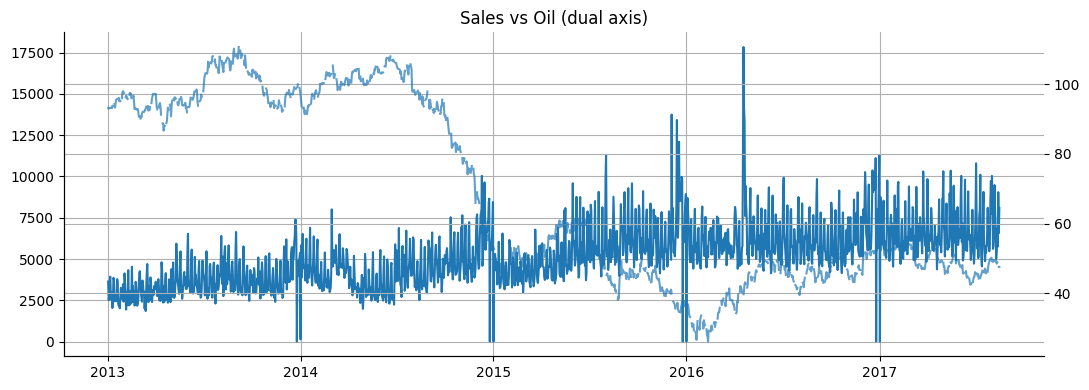

Korrelation (Total Sales vs Transactions): 0.658


In [16]:
# 1) Oil (national) auf Tagesbasis zu summierten Guayas-Sales joinen
try:
    daily_sales = df_filled.groupby(DATE_COL, as_index=False)[TARGET_COL].sum()
    oil = df_oil[[ 'date','dcoilwtico']].rename(columns={'date': DATE_COL})
    oil[DATE_COL] = pd.to_datetime(oil[DATE_COL], errors='coerce')
    merged = daily_sales.merge(oil, on=DATE_COL, how='left').sort_values(DATE_COL)
    corr = merged[[TARGET_COL, 'dcoilwtico']].corr().iloc[0,1]
    print(f"Korrelation (Total Sales vs Oil): {corr:.3f}")

    plt.figure(figsize=(11,4))
    plt.plot(merged[DATE_COL], merged[TARGET_COL], label='Total sales')
    plt.twinx()
    plt.plot(merged[DATE_COL], merged['dcoilwtico'], label='WTI', alpha=0.7)
    plt.title("Sales vs Oil (dual axis)")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Oil-Merge übersprungen:", e)

# 2) Transactions pro Store als Feature-Kandidat
try:
    df_transactions['date'] = pd.to_datetime(df_transactions['date'], errors='coerce')
    tx = (df_transactions
          .groupby([STORE_COL, 'date'])['transactions']
          .sum()
          .reset_index()
          .rename(columns={'date': DATE_COL}))
    # Nur Blick auf Korrelation auf Tages-Totals
    daily_tx = tx.groupby(DATE_COL)['transactions'].sum().reset_index()
    merged2 = daily_sales.merge(daily_tx, on=DATE_COL, how='left')
    corr2 = merged2[[TARGET_COL, 'transactions']].corr().iloc[0,1]
    print(f"Korrelation (Total Sales vs Transactions): {corr2:.3f}")
except Exception as e:
    print("Transactions-Analyse übersprungen:", e)

## 🧱 Block 16 — Schneller ACF-Check (nur visuell, aggregiert)

<Figure size 800x400 with 0 Axes>

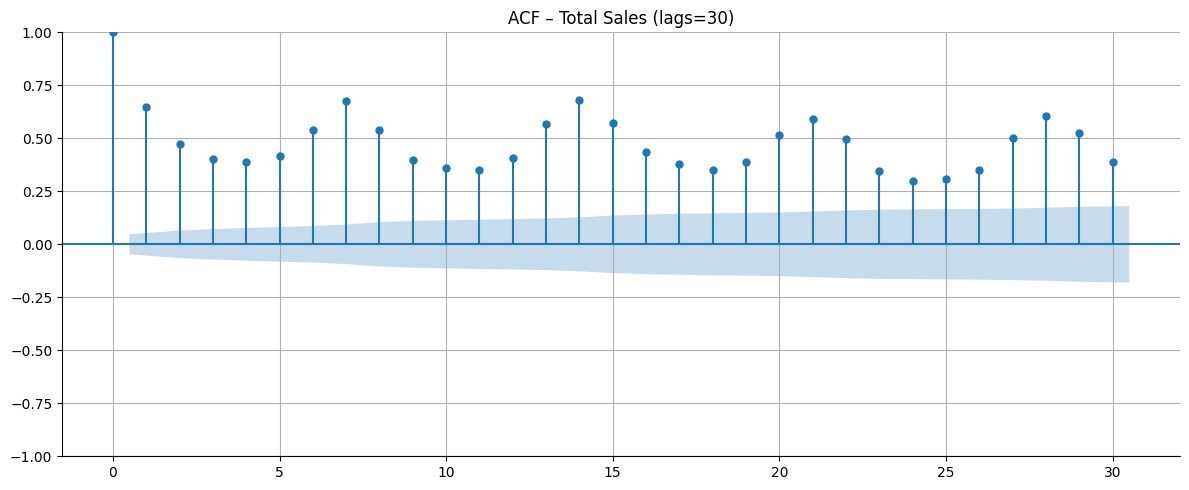

In [17]:
try:
    from statsmodels.graphics.tsaplots import plot_acf
    agg = df_filled.groupby(DATE_COL)[TARGET_COL].sum()
    plt.figure(figsize=(8,4))
    plot_acf(agg.values, lags=30)
    plt.title("ACF – Total Sales (lags=30)")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("ACF-Plot übersprungen:", e)


# 🧱 Block 17 — ML-Feature-Export für Week 2 (Jan–März 2014, Lags/Rollings + Kalender + Cyclic)

In [18]:
import numpy as np
import os

# 1) Kalenderfenster clampen (Week-2 Fokus)
start_2014 = pd.Timestamp('2014-01-01')
end_2014q1 = pd.Timestamp('2014-03-31')
ml = df_filled[(df_filled[DATE_COL] >= start_2014) & (df_filled[DATE_COL] <= end_2014q1)].copy()

# 2) Lags/Rollings je Serie (store×item/family) – nur Vergangenheit
def add_lag_roll(g):
    g = g.sort_values(DATE_COL)
    y = g[TARGET_COL]
    g['lag_1']   = y.shift(1)
    g['lag_7']   = y.shift(7)
    g['lag_14']  = y.shift(14)
    g['lag_30']  = y.shift(30)
    g['roll_mean_7'] = y.shift(1).rolling(7).mean()
    g['roll_std_7']  = y.shift(1).rolling(7).std()
    return g

ml = (
    ml.groupby([STORE_COL, ITEM_COL], group_keys=False)
      .apply(add_lag_roll)
)

# 3) Kalenderfeatures + zyklische Kodierung
ml['day_of_week'] = ml[DATE_COL].dt.dayofweek
ml['month']       = ml[DATE_COL].dt.month

# Zyklisch für DOW/Monat
ml['dow_sin'] = np.sin(2*np.pi*ml['day_of_week']/7)
ml['dow_cos'] = np.cos(2*np.pi*ml['day_of_week']/7)
ml['mon_sin'] = np.sin(2*np.pi*ml['month']/12)
ml['mon_cos'] = np.cos(2*np.pi*ml['month']/12)

# 4) Transactions (pro Store/Tag) und Oil (pro Tag)
if 'df_transactions' in globals():
    df_transactions['date'] = pd.to_datetime(df_transactions['date'], errors='coerce')
    tx = (df_transactions
          .groupby([STORE_COL, 'date'])['transactions']
          .sum()
          .reset_index()
          .rename(columns={'date': DATE_COL}))
    ml = ml.merge(tx, on=[STORE_COL, DATE_COL], how='left')

if 'df_oil' in globals():
    oil = df_oil[['date','dcoilwtico']].rename(columns={'date': DATE_COL})
    oil[DATE_COL] = pd.to_datetime(oil[DATE_COL], errors='coerce')
    oil['dcoilwtico'] = pd.to_numeric(oil['dcoilwtico'], errors='coerce').interpolate().ffill().bfill()
    ml = ml.merge(oil, on=DATE_COL, how='left')

# 5) Promo sauber in 0/1
if PROMO_COL is not None and PROMO_COL in ml.columns:
    ml[PROMO_COL] = ml[PROMO_COL].fillna(False).astype(int)

# 6) Anfangs-NaNs (durch Lags/Rollings) entfernen
before = len(ml)
ml = ml.dropna(subset=['lag_1','lag_7','roll_mean_7'])   # relativ konservativ
print(f"Drop wegen Lags/Rollings: {before-len(ml)} Zeilen")

# 7) Save für Week-2
SAVE_DIR = "/content/drive/MyDrive/time_series_course_guayas"
os.makedirs(SAVE_DIR, exist_ok=True)

out_name = "guayas_Q1_2014_ml_ready_store_sales.parquet" if ITEM_COL=='family' else "guayas_Q1_2014_ml_ready_favorita.parquet"
out_path = os.path.join(SAVE_DIR, out_name)

ml.to_parquet(out_path, index=False)
print("✅ ML-Datensatz gespeichert:", out_path)
print("Spalten (Auszug):", [c for c in ml.columns if c in [DATE_COL, STORE_COL, ITEM_COL, TARGET_COL, 'lag_1','lag_7','roll_mean_7','transactions','dcoilwtico']])
print("Zeitraum:", ml[DATE_COL].min(), "→", ml[DATE_COL].max(), "| rows:", len(ml))


Drop wegen Lags/Rollings: 78138 Zeilen
✅ ML-Datensatz gespeichert: /content/drive/MyDrive/time_series_course_guayas/guayas_Q1_2014_ml_ready_favorita.parquet
Spalten (Auszug): ['date', 'store_nbr', 'item_nbr', 'unit_sales', 'lag_1', 'lag_7', 'roll_mean_7', 'transactions', 'dcoilwtico']
Zeitraum: 2014-01-08 00:00:00 → 2014-03-31 00:00:00 | rows: 890595


## 🧱 Block 18 — Sanity-Check der gespeicherten Artefakte (für Week 2/3)


===== CSV-Sample (df_prepared_guayas_favorita) =====
Shape: (50000, 4)
Zeitraum: 2013-01-02 00:00:00 → 2017-08-15 00:00:00
NaN-Rate (Pflichtspalten):
date          0.0
store_nbr     0.0
item_nbr      0.0
unit_sales    0.0
dtype: float64
Guayas-Anteil (Sample): 1.000


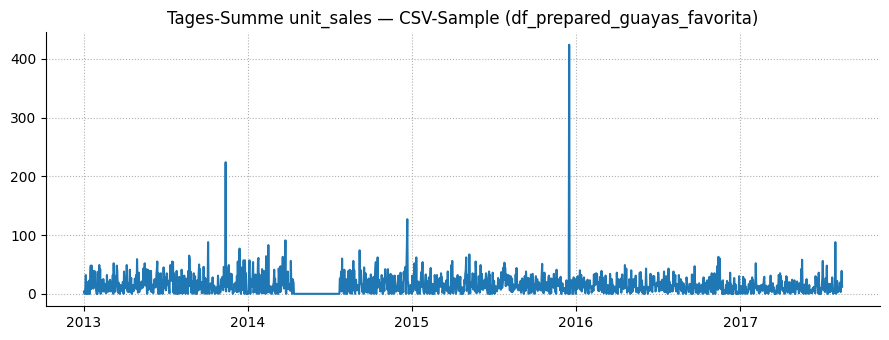


Parquet-Metadaten: row_groups=1 | rows=890595

===== Parquet-Sample (guayas_Q1_2014_ml_ready_favorita) =====
Shape: (60000, 4)
Zeitraum: 2014-01-08 00:00:00 → 2014-03-31 00:00:00
NaN-Rate (Pflichtspalten):
date          0.0
store_nbr     0.0
item_nbr      0.0
unit_sales    0.0
dtype: float64
Guayas-Anteil (Sample): 1.000


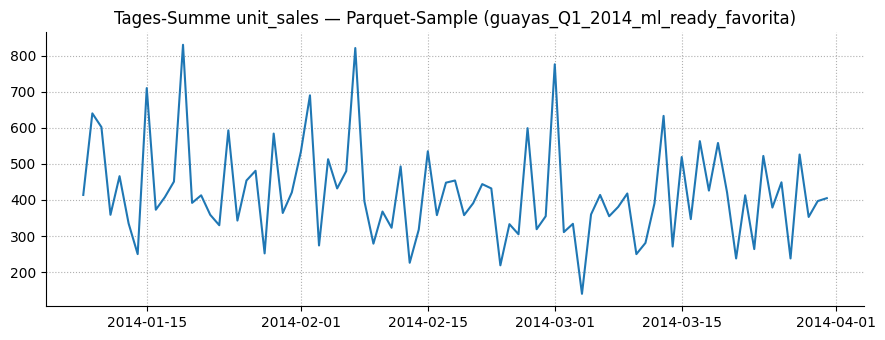


⇒ Quelle für Week 2/3: /content/drive/MyDrive/time_series_course_guayas/guayas_Q1_2014_ml_ready_favorita.parquet

Parquet-Metadaten: row_groups=1 | rows=890595
Q1-Check (Mini): 2014-01-08 00:00:00 → 2014-03-31 00:00:00 | rows: 20000


In [19]:
# 🧱 Block 18 — Lite: RAM-schonender Sanity-Check (lädt nur kleine Häppchen)
import os, warnings, gc, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

CSV_PATH = "/content/drive/MyDrive/time_series_course_guayas/df_prepared_guayas_favorita.csv"
PQ_PATH  = "/content/drive/MyDrive/time_series_course_guayas/guayas_Q1_2014_ml_ready_favorita.parquet"

# Nur Pflichtspalten für Favorita-Schema
REQ_COLS = ["date","store_nbr","item_nbr","unit_sales"]

def report_df(df, name):
    df = df.copy()
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
    print(f"\n===== {name} =====")
    print("Shape:", df.shape)
    miss = [c for c in REQ_COLS if c not in df.columns]
    if miss:
        print("⚠️ Fehlende Pflichtspalten:", miss)
        return
    print("Zeitraum:", df["date"].min(), "→", df["date"].max())
    print("NaN-Rate (Pflichtspalten):")
    print(df[REQ_COLS].isna().mean().round(4))

    # Guayas-Anteil (falls df_stores im Kernel existiert)
    if "df_stores" in globals() and "state" in df_stores.columns:
        guayas_ids = df_stores.loc[
            df_stores["state"].astype(str).str.upper().str.strip()=="GUAYAS", "store_nbr"
        ].unique()
        if len(guayas_ids):
            share = (df["store_nbr"].isin(guayas_ids)).mean()
            print(f"Guayas-Anteil (Sample): {share:.3f}")

    # Mini-Plot (auf Sample begrenzen)
    try:
        daily = (df.groupby("date", as_index=False)["unit_sales"].sum()
                   .sort_values("date"))
        if len(daily) > 5:
            plt.figure(figsize=(9,3.5))
            plt.plot(daily["date"], daily["unit_sales"])
            plt.title(f"Tages-Summe unit_sales — {name}")
            plt.grid(True, ls=":")
            plt.tight_layout(); plt.show()
    except Exception as e:
        print("Plot übersprungen:", e)

def peek_parquet_safely(path, cols=REQ_COLS, rows_cap=50000, rowgroups_cap=2):
    """Liest nur die ersten 1–2 RowGroups & Pflichtspalten (pyarrow), um RAM zu sparen."""
    import pyarrow.parquet as pq
    pf = pq.ParquetFile(path)
    total_rows = pf.metadata.num_rows
    print(f"\nParquet-Metadaten: row_groups={pf.num_row_groups} | rows={total_rows}")
    parts = []
    rows_read = 0
    for rg in range(min(pf.num_row_groups, rowgroups_cap)):
        table = pf.read_row_group(rg, columns=cols)
        df_rg = table.to_pandas()
        parts.append(df_rg)
        rows_read += len(df_rg)
        if rows_read >= rows_cap:
            break
    sample = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=cols)
    # Auf rows_cap kürzen (Sicherheitsgurt)
    if len(sample) > rows_cap:
        sample = sample.iloc[:rows_cap].copy()
    return sample

def peek_csv_safely(path, cols=REQ_COLS, nrows=50000):
    """Liest nur Pflichtspalten & begrenzte Zeilen (pandas)."""
    # Falls CSV mehr Spalten hat: usecols schränkt ein
    return pd.read_csv(path, usecols=[c for c in cols if c], nrows=nrows, low_memory=False)

# 1) CSV-Sample prüfen (falls vorhanden)
if os.path.isfile(CSV_PATH):
    try:
        df_csv = peek_csv_safely(CSV_PATH, REQ_COLS, nrows=50000)
        report_df(df_csv, "CSV-Sample (df_prepared_guayas_favorita)")
        del df_csv; gc.collect()
    except Exception as e:
        print("CSV-Sample Fehler:", e)
else:
    print("ℹ️ CSV nicht gefunden:", CSV_PATH)

# 2) Parquet-Sample prüfen (Week-2/3 Input bevorzugt)
if os.path.isfile(PQ_PATH):
    try:
        df_pq = peek_parquet_safely(PQ_PATH, REQ_COLS, rows_cap=60000, rowgroups_cap=2)
        report_df(df_pq, "Parquet-Sample (guayas_Q1_2014_ml_ready_favorita)")
        del df_pq; gc.collect()
    except Exception as e:
        print("Parquet-Sample Fehler:", e)
else:
    print("ℹ️ Parquet nicht gefunden:", PQ_PATH)

# 3) Entscheidung für Week 2/3 Quelle (bevorzugt Parquet)
DATA_FOR_W23 = PQ_PATH if os.path.isfile(PQ_PATH) else (CSV_PATH if os.path.isfile(CSV_PATH) else None)
print("\n⇒ Quelle für Week 2/3:", DATA_FOR_W23 if DATA_FOR_W23 else "⚠️ keine Datei gefunden")

# 4) Mini-Endkontrolle: Nur 2.000 Zeilen laden und Q1-Filter testen (super safe)
if DATA_FOR_W23:
    # Parquet minimal: nur Pflichtspalten, nur 1 RowGroup (sehr klein)
    if DATA_FOR_W23.endswith(".parquet"):
        df_mini = peek_parquet_safely(DATA_FOR_W23, REQ_COLS, rows_cap=20000, rowgroups_cap=1)
    else:
        df_mini = peek_csv_safely(DATA_FOR_W23, REQ_COLS, nrows=20000)

    df_mini["date"] = pd.to_datetime(df_mini["date"], errors="coerce")
    df_mini = df_mini[(df_mini["date"] >= "2014-01-01") & (df_mini["date"] < "2014-04-01")].copy()
    print("Q1-Check (Mini):", df_mini["date"].min(), "→", df_mini["date"].max(), "| rows:", len(df_mini))
    del df_mini; gc.collect()

## 🧱 Block 18b — Handover-Artefakte für Week 2/3 (Q1-Parquet + Metadaten)

In [21]:
import os, json, hashlib
import pandas as pd
from datetime import datetime

# Pfade
BASE_DIR = "/content/drive/MyDrive/time_series_course_guayas"
CSV_PATH = os.path.join(BASE_DIR, "df_prepared_guayas_favorita.csv")  # aus Block 8
PQ_PATH  = os.path.join(BASE_DIR, "guayas_Q1_2014_ml_ready_favorita.parquet")
META_JS  = os.path.join(BASE_DIR, "handover_metadata.json")

REQ_COLS = ["date","store_nbr","item_nbr","unit_sales"]

def sha1_of_file(path, chunksize=2**20):
    h = hashlib.sha1()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunksize)
            if not b: break
            h.update(b)
    return h.hexdigest()

need_build = not os.path.isfile(PQ_PATH)
if need_build:
    assert os.path.isfile(CSV_PATH), f"CSV nicht gefunden: {CSV_PATH}"

    # Nur Pflichtspalten lesen (RAM-schonend)
    usecols = [c for c in REQ_COLS if c]
    df = pd.read_csv(CSV_PATH, usecols=usecols, low_memory=False)
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # Q1/2014
    df_q1 = df[(df["date"] >= "2014-01-01") & (df["date"] < "2014-04-01")].copy()

    # Dtypes festziehen (robust für Week 2/3)
    df_q1["store_nbr"] = df_q1["store_nbr"].astype("int32")
    df_q1["item_nbr"]  = df_q1["item_nbr"].astype("int32")
    df_q1["unit_sales"]= pd.to_numeric(df_q1["unit_sales"], errors="coerce").astype("float32")

    # Parquet schreiben
    os.makedirs(BASE_DIR, exist_ok=True)
    df_q1.to_parquet(PQ_PATH, index=False)
    print(f"✅ Q1-Parquet gespeichert → {PQ_PATH}  | rows={len(df_q1):,}")
else:
    print(f"ℹ️ Q1-Parquet bereits vorhanden → {PQ_PATH}")

df_chk = pd.read_parquet(PQ_PATH, columns=REQ_COLS)
df_chk["date"] = pd.to_datetime(df_chk["date"])
print("🔎 Check:", df_chk["date"].min(), "→", df_chk["date"].max(), "| rows:", len(df_chk))

meta = {
    "created_at": datetime.utcnow().isoformat() + "Z",
    "producer": "week1_notebook",
    "paths": {
        "csv": CSV_PATH,
        "parquet_q1": PQ_PATH
    },
    "schema": {
        "required_cols": REQ_COLS,
        "dtypes": {k: str(df_chk[k].dtype) for k in REQ_COLS}
    },
    "date_range_q1": {
        "min": df_chk["date"].min().strftime("%Y-%m-%d"),
        "max": df_chk["date"].max().strftime("%Y-%m-%d")
    },
    "rows_q1": int(len(df_chk)),
    "hash": {
        "parquet_sha1": sha1_of_file(PQ_PATH)
    },
    "notes": "Dieses JSON hilft Week 2/3 beim schnellen Auffinden & Validieren."
}
with open(META_JS, "w") as f:
    json.dump(meta, f, indent=2)
print("📝 Metadata gespeichert →", META_JS)

SAMPLE_CSV = os.path.join(BASE_DIR, "sample_q1_small.csv")
df_chk.sample(min(2000, len(df_chk))).to_csv(SAMPLE_CSV, index=False)
print("📦 Sample exportiert →", SAMPLE_CSV)

del df_chk

ℹ️ Q1-Parquet bereits vorhanden → /content/drive/MyDrive/time_series_course_guayas/guayas_Q1_2014_ml_ready_favorita.parquet
🔎 Check: 2014-01-08 00:00:00 → 2014-03-31 00:00:00 | rows: 890595
📝 Metadata gespeichert → /content/drive/MyDrive/time_series_course_guayas/handover_metadata.json
📦 Sample exportiert → /content/drive/MyDrive/time_series_course_guayas/sample_q1_small.csv


In [22]:
SAVE_DIR = "/content/drive/MyDrive/time_series_course_guayas"
os.makedirs(SAVE_DIR, exist_ok=True)

fname = "df_prepared_guayas_store_sales.csv" if HAS_FAMILY and not HAS_ITEM else "df_prepared_guayas_favorita.csv"
save_path = os.path.join(SAVE_DIR, fname)
df_filled.to_csv(save_path, index=False)
print("gespeichert →", save_path)


gespeichert → /content/drive/MyDrive/time_series_course_guayas/df_prepared_guayas_favorita.csv
